In [1]:
from glob import glob
import os as os
import matplotlib.pyplot as plt   
%matplotlib inline
import numpy as np  
import pandas as pd
import scipy as scipy
import time
from keras.utils import np_utils

np.random.seed(123)

import matplotlib.image as mpimg
import keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input, ZeroPadding2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers

from keras.applications.resnet50 import ResNet50

from sklearn.preprocessing import LabelEncoder
from keras.optimizers import SGD, Adam

import itertools
from sklearn.metrics import confusion_matrix
from itertools import cycle
from sklearn.metrics import roc_curve, auc

plt.rcParams['figure.figsize'] = (10, 6)  

Using TensorFlow backend.


In [2]:
def generate_data(data_type, tissue_type):
    read_tiles_path = "/home/a0121533/fyp2017dsap/Phase_0/Lung_Liver_classifier/normalized/" + data_type + "/" + tissue_type + "s/"
    tiles = glob(read_tiles_path + "*.png")    
    
    X = []
    Y = []
    
    for tile in tiles:
        if tissue_type == 'liver':
            Y.append(0)
        else:
            Y.append(1)
        
        tile_data = mpimg.imread(tile)
        X.append(tile_data)
    
    return X, Y

import matplotlib.pyplot as plt

def pie_chart(u, c):
    # Data to plot
    labels = u
    sizes = c

    # Plot
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0)

    plt.axis('equal')
    plt.show()

sanity check for train
[[   0    1]
 [2078 2081]]


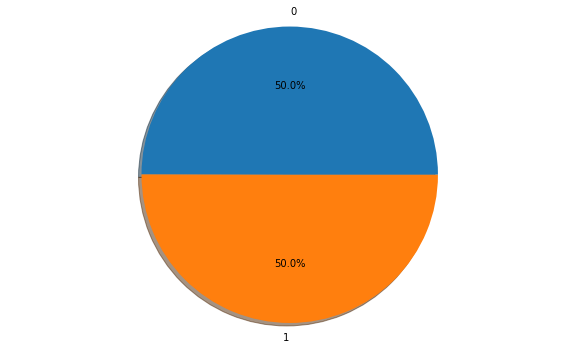

sanity check for test
[[  0   1]
 [894 897]]


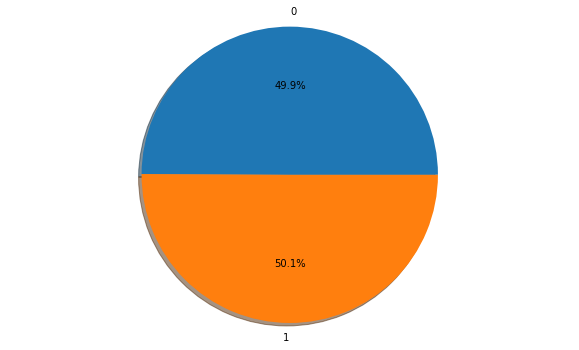

Generating training data
Generating test data
Sanity Check
y_test_encoded: (1791, 2)
y_train_encoded: (4159, 2)
x_train: (4159, 128, 128, 3)
x_test: (1791, 128, 128, 3) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 121, 121, 8)       1544      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 16)        2064      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 32)        2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1

In [3]:
img_width, img_height = 128, 128

def model() :
    model = Sequential()
    model.add(Conv2D(8, (8, 8), activation='relu', input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    print(model.summary())
    return model

if __name__ == '__main__':
   
    lung_X_train, lung_Y_train = generate_data("train", "lung")
    liver_X_train, liver_Y_train = generate_data("train", "liver")
    
    X_train, Y_train = np.concatenate((lung_X_train, liver_X_train)), np.concatenate((lung_Y_train, liver_Y_train))
    
    lung_X_valid, lung_Y_valid = generate_data("validation", "lung")
    liver_X_valid, liver_Y_valid = generate_data("validation", "liver")
    
    X_valid, Y_valid = np.concatenate((lung_X_valid, liver_X_valid)), np.concatenate((lung_Y_valid, liver_Y_valid))
    
    
    encoder = LabelEncoder()
    encoder.fit(Y_train)
    y_train_encoded = encoder.transform(Y_train)
    y_train_encoded = np_utils.to_categorical(y_train_encoded)

    print("sanity check for train")
    u, c = np.unique(Y_train, return_counts=True)
    print(np.asarray((u, c)))
    pie_chart(u,c)

    encoder = LabelEncoder()
    encoder.fit(Y_valid)
    y_test_encoded = encoder.transform(Y_valid)
    y_test_encoded = np_utils.to_categorical(y_test_encoded)

    print("sanity check for test")
    u, c = np.unique(Y_valid, return_counts=True)
    print(np.asarray((u, c)))
    pie_chart(u,c)
    
    
    train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.02,
        height_shift_range=0.02,
        rotation_range=4)

    test_datagen = ImageDataGenerator()

    print("Generating training data")
    # use image data generator for training data
    for x_batch, y_batch in train_datagen.flow(X_train, y_train_encoded, batch_size=X_train.shape[0]):
        X_train = x_batch
        y_train_encoded = y_batch
        break 

    print("Generating test data")
    # use image data generator for test data
    for x_batch, y_batch in test_datagen.flow(X_valid, y_test_encoded, batch_size=X_valid.shape[0]):
        X_valid = x_batch
        y_test_encoded = y_batch
        break 


    print("Sanity Check")
    print("y_test_encoded:", y_test_encoded.shape)
    print("y_train_encoded:", y_train_encoded.shape)
    print("x_train:", X_train.shape)
    print("x_test:", X_valid.shape, "\n")
    
    # Load our model
    model = model()

    # Start Fine-tuning
    hfit = model.fit(X_train, y_train_encoded,
              batch_size=10,
              epochs=30,
              shuffle=True,
              verbose=1,
              validation_data=(X_valid, y_test_encoded),
            )

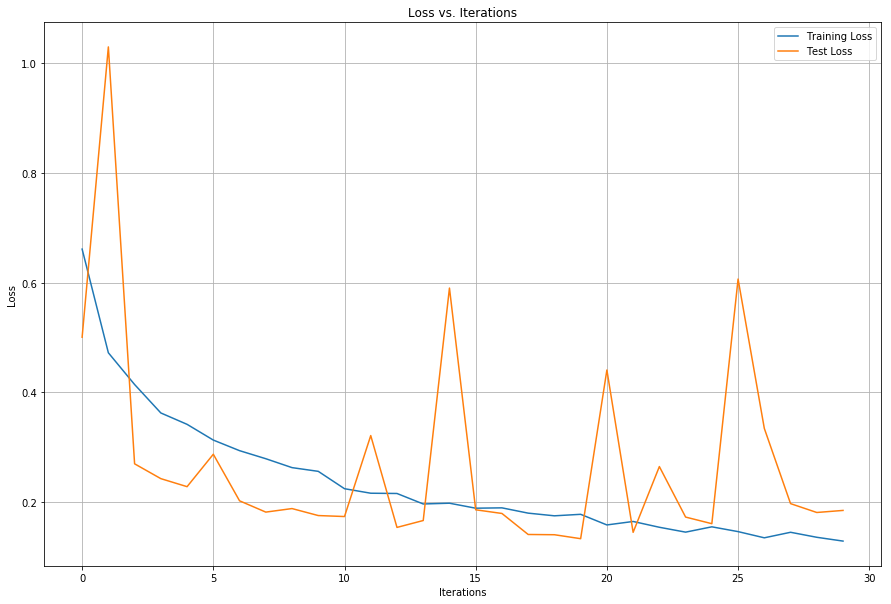

In [4]:
plt.rcParams['figure.figsize'] = (15, 10)  
plt.plot(hfit.history['loss'])
plt.plot(hfit.history['val_loss'])
plt.title("Loss vs. Iterations")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.grid("on")
plt.legend(("Training Loss", "Test Loss"), loc="upper right")

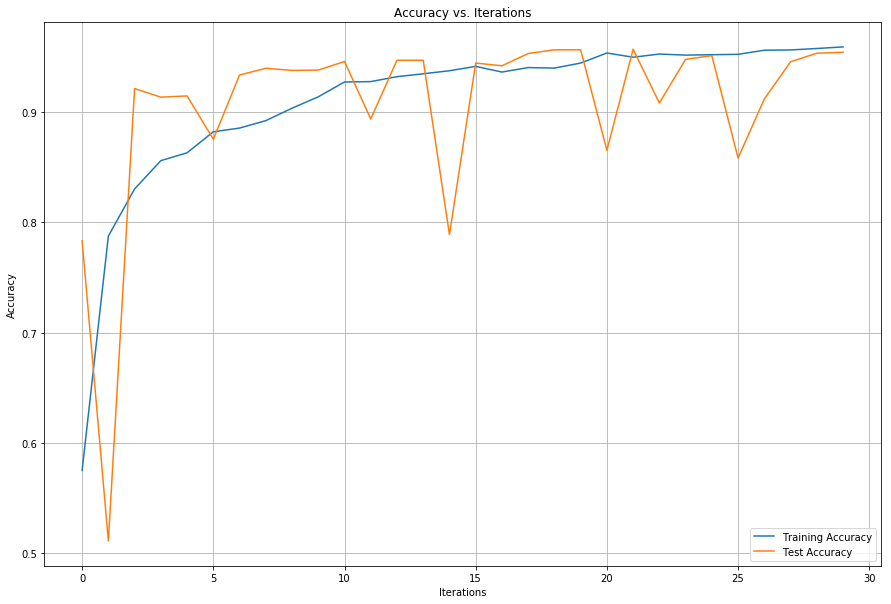

In [11]:
plt.rcParams['figure.figsize'] = (15, 10)  
plt.plot(hfit.history['acc'])
plt.plot(hfit.history['val_acc'])
plt.title("Accuracy vs. Iterations")
plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.grid("on")
plt.legend(("Training Accuracy", "Test Accuracy"), loc="lower right")

In [6]:
y_score = model.predict(X_valid)

false_pr_dict = dict()
true_pr_dict = dict()
area_under_curve_dict = dict()

# Iterate through each class
for i in range(2):
    false_pr_dict[i], true_pr_dict[i], _ = roc_curve(y_test_encoded[:, i], y_score[:, i])
    area_under_curve_dict[i] = auc(false_pr_dict[i], true_pr_dict[i])

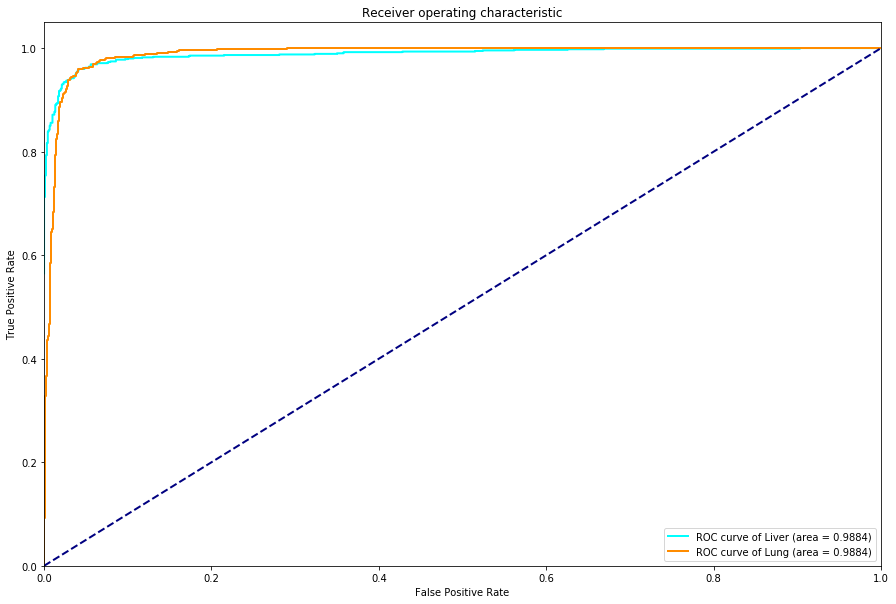

In [10]:
plt.figure()

colors = cycle(['aqua', 'darkorange'])
classes = ['Liver', 'Lung']

for index, c in zip(range(2), colors):
    plt.plot(false_pr_dict[index], 
             true_pr_dict[index], 
             label='ROC curve of {0} (area = {1:0.4f})'
             ''.format(classes[index], area_under_curve_dict[index]), 
             color=c, lw=2)

# Insert Labels
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
    
# Set Limits
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

# Plot naive line
plt.plot([0, 1], [0, 1], lw=2, linestyle='--',  color='navy')

# Add Title
plt.title('Receiver operating characteristic')

# Add Legend
plt.legend(loc="lower right")
plt.show()

Confusion matrix, without normalization
[[866  28]
 [ 52 845]]


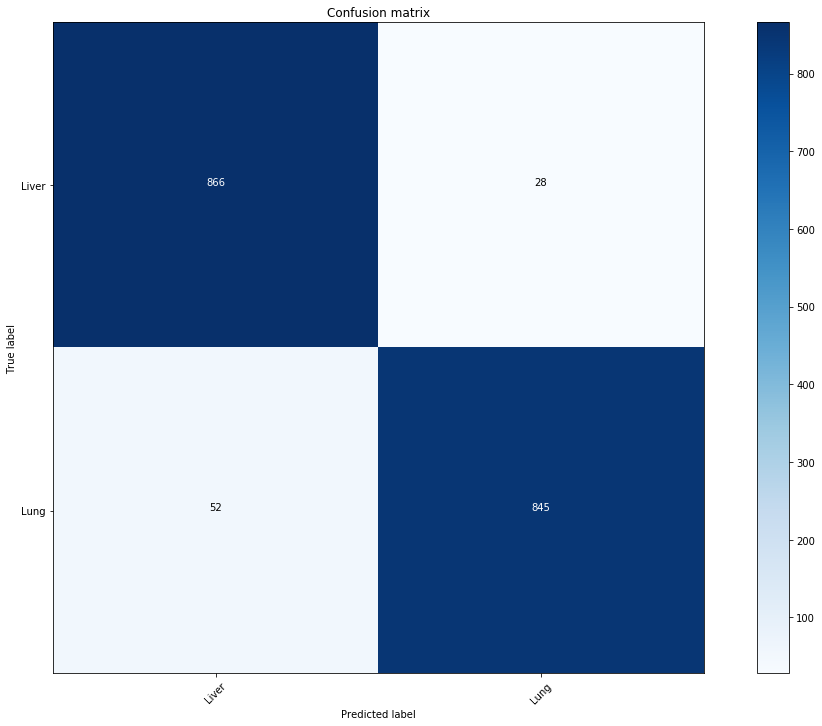

In [9]:
def show_conf_mat(matrix_array, c_list, title):
    
    print('Confusion matrix, without normalization')

    print(matrix_array)

    # Set layout
    plt.imshow(matrix_array, interpolation='nearest', cmap=plt.matrix_array.Blues)
    plt.tight_layout()
    plt.colorbar()
    
    ticks = np.arange(len(c_list))
    plt.yticks(ticks, c_list)
    plt.xticks(ticks, c_list, rotation=45)
        
    for i, j in itertools.product(range(matrix_array.shape[0]), 
                                  range(matrix_array.shape[1])):
        
        plt.text(j, i, format(matrix_array[i, j], 'd'),
                 color="white" if matrix_array[i, j] > matrix_array.max() / 2. else "black",
                horizontalalignment="center")

    # Insert Labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Insert Title
    plt.title(title)
    
    

predictions = np.argmax(y_test_encoded,axis=1)
truth = np.argmax(y_score,axis=1)

plt.figure()
np.set_printoptions(precision=2)

show_conf_mat(confusion_matrix(predictions, truth), ["Liver", "Lung"], 'Confusion matrix')